In [13]:
"""
Iz skupa podataka smo izbacili kolone koje uvijek imaju istu vrijednost(STANJE je uvijek polovno i slično).
Za kolonu Gorivo, spajali smo tipove koji koriste prirodni gas.
"""

'\nIz skupa podataka smo izbacili kolone koje uvijek imaju istu vrijednost(STANJE je uvijek polovno i slično).\nZa kolonu Gorivo, spajali smo tipove koji koriste prirodni gas.\n'

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
df_stari = pd.read_csv('jedinstveni.csv')
df = pd.read_csv('ocisceni.csv')

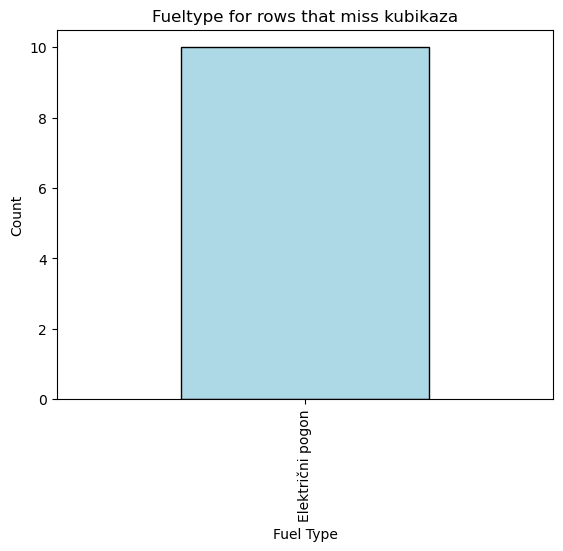

In [25]:
"""
Ukoliko je kubikaža neunesena, koji je to tip vozila? 
"""
missing_rows = df_stari[df_stari['Kubikaža'].isnull()]
missing_rows['Gorivo'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black') 
plt.title('Fueltype for rows that miss kubikaza')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

# Sva vozila koja nemaju unesenu kubikažu su zapravo električna vozila. U čišćenju podataka smo ta vozila izbacili zajedno sa hibridnim vozilima jer 
# ih je bilo oko 40 ---- objasnjenje zasto smo to izbacili da se model ponasa losije ako se ostanu ---- ovo treba da testiramo na modelima

Na boxplotu, možemo videti da je medijan neoštećenih vozila na poziciji koja je blizu maksimalne vrijednosti vozila koja su oštećena. 
Želimo da vidimo koja su to vozila koja su oštećena. 

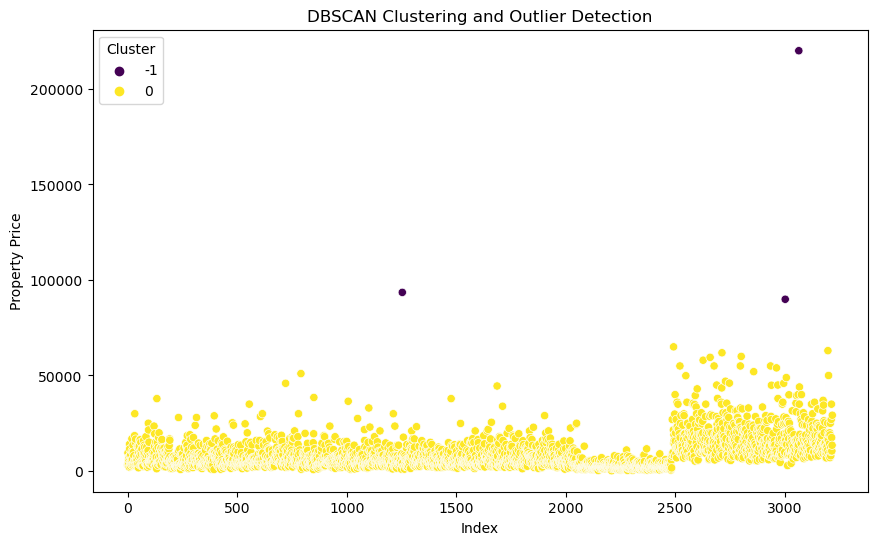

,Cena,Model,Marka,Godište,Kubikaža,Gorivo,Karoserija,Snaga motora,Kilometraža,Oštećenje,Pogon,Klima,Materijal enterijera,Boja,Emisiona klasa motora,Safety_Feature_Count,Equipment_Feature_Count,Menjač_Manuelni,Cetiri_Vrata,Cluster
1254,93500.0,S 63 AMG,Mercedes Benz,2015.0,5461.0,0,3,430.0,119983.0,Nije oštećen,0,Automatska klima,1,2,3,3.0,6.0,0,0,-1
3003,89900.0,G 350,Mercedes Benz,2018.0,2987.0,1,0,180.0,28165.0,Nije oštećen,0,Automatska klima,3,8,3,4.0,4.0,0,1,-1
3065,220000.0,Urus,Lamborghini,2018.0,3996.0,0,0,478.0,84193.0,Nije oštećen,0,Automatska klima,3,6,3,4.0,3.0,0,1,-1


In [26]:

prices = df[['Cena']].values

# Step 3: Normalize or scale the data (optional, depending on the range of prices)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
prices_scaled = scaler.fit_transform(prices)

# Step 4: Apply DBSCAN
# Adjust eps (radius) and min_samples (minimum points in a cluster) based on your data
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(prices_scaled)

# Step 5: Add DBSCAN labels to the dataframe
df['Cluster'] = labels

# Outliers are labeled as -1 by DBSCAN
outliers = df[df['Cluster'] == -1]

# Step 6: Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=range(len(df)), y='Cena', hue='Cluster', palette='viridis')
plt.title('DBSCAN Clustering and Outlier Detection')
plt.xlabel('Index')
plt.ylabel('Property Price')
plt.legend(title='Cluster')
plt.show()
#research question: celija koda pa ima plot i posle plota u jednoj recenici zakljucak.
outliers

Vidimo da su auta koja su autlajeri zapravo retka luksuzna auta. S obzirom na to da ih ima tri, izbacićemo ih iz skupa

In [27]:
df = df[df['Cluster'] != -1].drop(columns=['Cluster'])

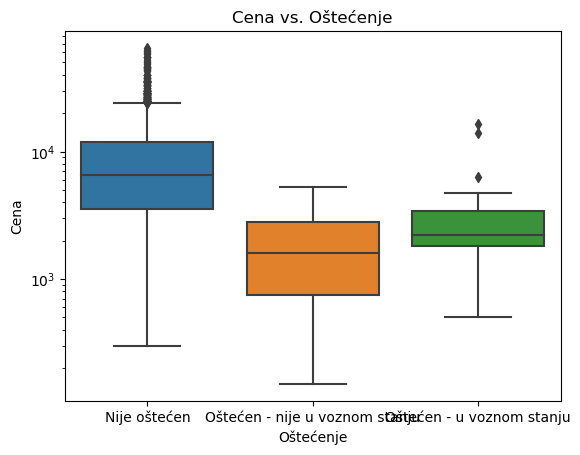

In [28]:
sns.boxplot(x='Oštećenje', y='Cena', data=df)
plt.yscale('log')
plt.title('Cena vs. Oštećenje')
plt.show()
#ako brkovi nisu isti onda su podaci nakrivljeni i ako medijana nije centrirana ----
#ako se jasno boksovi razdvajaju ---- onda ima smisla, ako su svi iste velicine onda su vjv slicni i moze da se izbaci.
#treba da gledamo kako potencijalno autlajeri mogu biti problematicni.
#probamo model i vidimo kakvi su rezultati i gdje ima gresaka
#koje instance podataka kvare podatke.

Sa grafika uočavamo da tri klase koje imamo su dosta separatisane. Oštećenje dosta utiče na cijenu i stoga pravimo novo obilježje koje ćemo enkodovati pomoću label encodinga.

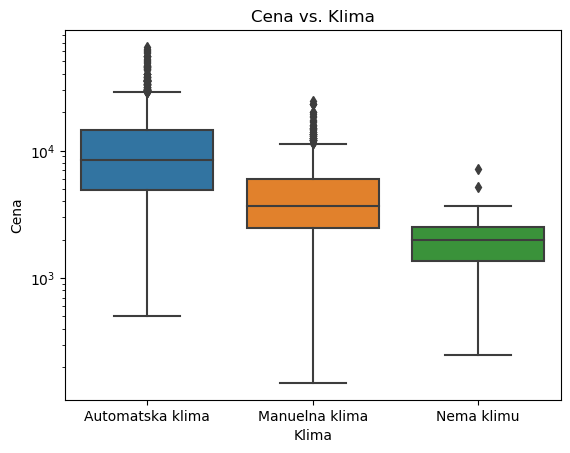

In [29]:
# izbacicemo ove sto nemaju najveovatnije a onda one hot encoding
df['Klima'].value_counts()
sns.boxplot(x='Klima', y='Cena', data=df)
plt.yscale('log')
plt.title('Cena vs. Klima')
plt.show()

# df = df[df['Klima'] != "Nema klimu"]
# #one hot encoding
# #df = pd.get_dummies(df, columns=['Klima'], drop_first=True)
# df['Klima'].value_counts()
# # one hot encoding 
# df['Automatska_Klima'] = (df['Klima'] == 'Automatska klima').astype(int)
# df = df.drop('Klima', axis = 1)
# df['Automatska_Klima'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')

Na osnovu plotova, vidimo da kada auto nema klimu, da je cena u proseku manja i da je njen box odvojen. Tako]e, boksovi imaju manjih preklapanja ali su na različitim dijelovima skale. Zaključak: Kada vozilo nema klimu, to dosta utiče na cijenu.

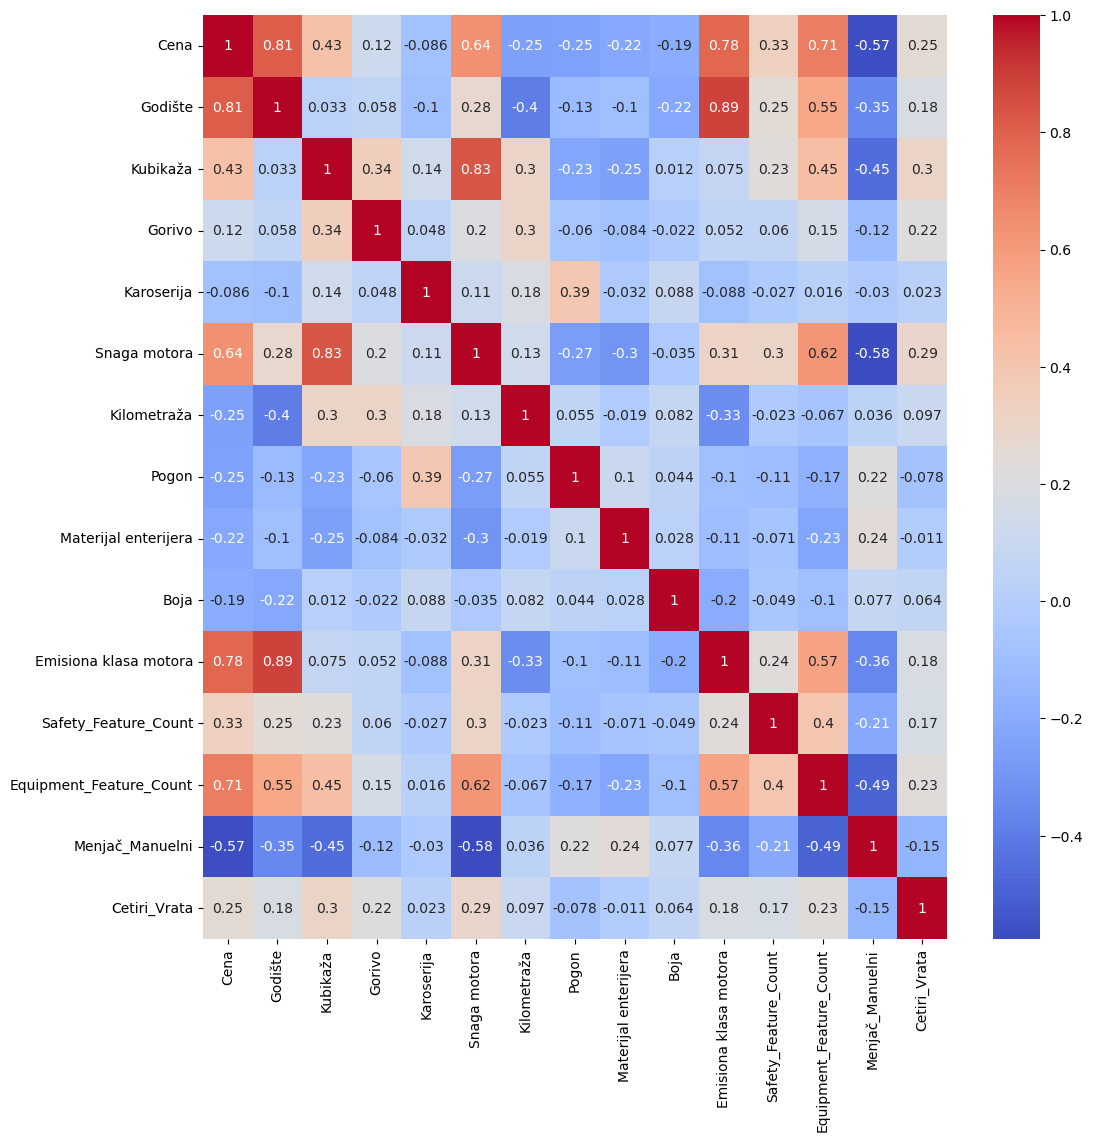

In [30]:
# racunanje korelacione matrice, ----- gledamo samo linearnu zavisnost ovdje
#zasto spearman a ne default pearson? -- jer je nas dataset poprilicno nebalansiran

correlation_matrix = df.corr(method = 'spearman')
# print(correlation_matrix)

# vizualiyacija pomocu heatmap-e
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Na osnovu korelacione matrice, vidimo da Snaga motora i Kubikaža imaju vrijednost korelaciju 0,83. Takođe, godište i emisiona klasa motora imaju korelaciju 0,89. Te dvije zavisnosti dalje obrađujemo.


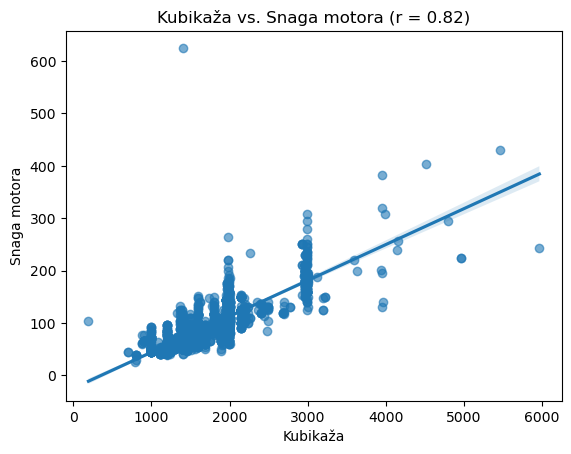

In [31]:
corr = df[['Kubikaža', 'Snaga motora']].corr().iloc[0,1]

# 2. Scatter with regression line
sns.regplot(x='Kubikaža', y='Snaga motora', data=df, scatter_kws={'alpha':0.6})

# 3. Add correlation value to the plot
plt.title(f'Kubikaža vs. Snaga motora (r = {corr:.2f})')
plt.show()

Iako vidimo na grafiku da kubikaža i snaga motora imaju određeni zajednički rast, ipak vidimo da ima dosta odstupanja, 
stoga ostavljamo obje kolone.

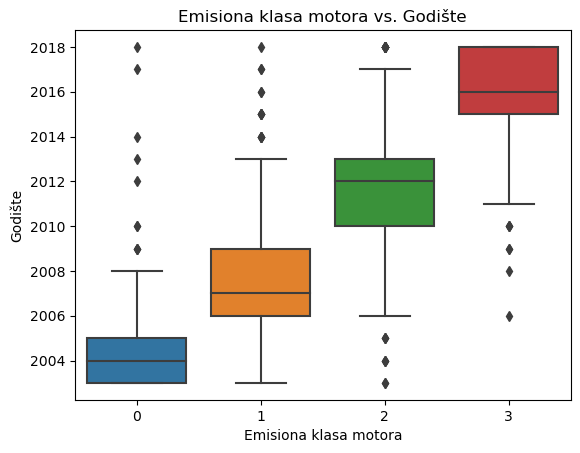

In [33]:
df['Emisiona klasa motora'].value_counts()
sns.boxplot(x='Emisiona klasa motora', y='Godište', data=df)

plt.title('Emisiona klasa motora vs. Godište')
plt.show()

Vidimo da kako raste godište, raste i emisiona klasa motora. Boksovi su separatisani. Zaključujemo da ova dva obeležja imaju veliku korelaciju, i spojićemo ih u jedan(Izbacićemo emisionu klasu motora).

In [34]:
#Normalizacija podataka kao priprema za modele
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Kubikaža'] = scaler.fit_transform(df[['Kubikaža']])
df['Kilometraža'] = scaler.fit_transform(df[['Kilometraža']])
df['Snaga motora'] = scaler.fit_transform(df[['Snaga motora']])
df['Godište'] = scaler.fit_transform(df[['Godište']])
df['Oštećenje'] = label_encoder.fit_transform(df['Oštećenje'])
df['Klima'] = label_encoder.fit_transform(df['Klima'])

#veliki broj klasa, koristićemo frequent encoding ---- bas zato sto je nebalansiran skup, mijenja se kategorija sa brojem pojavljivanja u skupu
frequency_map = df['Marka'].value_counts(normalize=True)
df['Marka'] = df['Marka'].map(frequency_map)
df = df.drop('Model', axis=1)

df.to_csv('sredjeni.csv',index=False)